In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching import results_path
from torchvision.utils import make_grid

def generate_samples(trained_model, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(x_test.shape[0], 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    x_1 = x_1.view(-1, 1, 28, 28)
    x_t = x_t.view(-1, x_t.shape[1], 1, 28, 28)
    return x_1, x_t, t

def mnist_noise_bridge(path, 
                       x_input, 
                       num_timesteps=1000,  
                       time_epsilon=0.0,
                       num_img=5,
                       num_timesteps_displayed=20,
                       save_path=None):
    
    img_1, img_hist, time_steps = generate_samples(path, x_input[:num_img], num_timesteps=num_timesteps,  time_epsilon=time_epsilon, device=x_input.device)
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img))
    N = img_hist.size(1)
    dt = N // num_timesteps_displayed
    
    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            tau = time_steps[idx]
            images = img_hist[:, idx, :]
        else:
            tau = time_steps[-1]
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze(), cmap='gray')
            if i == 0: axs[i, j].set_title(r'$\tau = {0}$'.format(round(tau.item(),2)))
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path+'/bridge_example.png')

def get_mnist_test_samples(trained_model, 
                           which = 'source', # 'source' or 'target
                           class_label=None, 
                           sample_size=800, 
                           device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    images = []
    source = crm.dataloader_0.test()
    target = crm.dataloader_1.test()

    for batch in source if which == 'source' else target:
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 1, 28, 28)
            images.append(sample)

    return torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)


def mnist_grid(sample, save_path='.', num_img=5, nrow=8, figsize=(10,10)):
    _, _= plt.subplots(1,1, figsize=figsize)
    sample = sample[:num_img]
    img = make_grid(sample, nrow=nrow)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.savefig(save_path+'/selected_sample.png')
    plt.show()

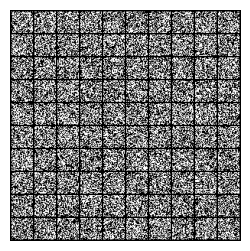

1000it [00:27, 36.58it/s]


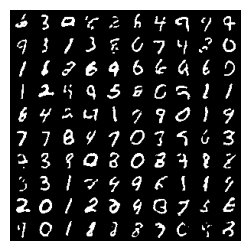

1000it [00:26, 37.04it/s]


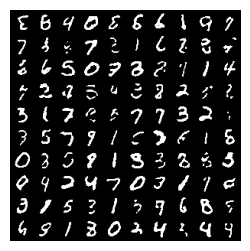

1000it [00:26, 37.09it/s]


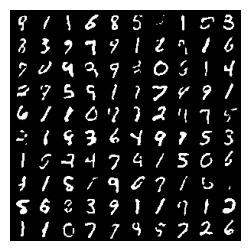

1000it [00:26, 37.45it/s]


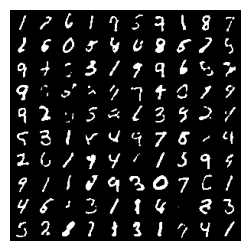

In [2]:
path = "mnist/uniform_coupling/noise_to_mnist_unet_cfm_1.0/run"

noise = get_mnist_test_samples(path, class_label=None, sample_size=100, device="cuda:1")
mnist_grid(noise, nrow=10, num_img=100, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.1, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.02, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.01, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

samples,_ , _ = generate_samples(path, noise, num_timesteps=1000,  time_epsilon=0.0, device="cuda:1")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

# EMNIST $\to$ MNIST

constant thermostat with: $\gamma=0.5$:

source data:

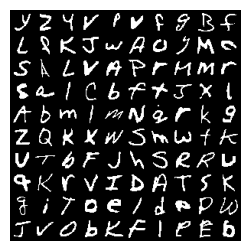

In [4]:
path = "emnist_to_mnist_unet_ConstantThermostat_gamma_0.5_max_0.0/run"
letters = get_mnist_test_samples(path, which='source', class_label=None, sample_size=100, device="cuda:0")
mnist_grid(letters, nrow=10, num_img=100, figsize=(3,3))

target data:

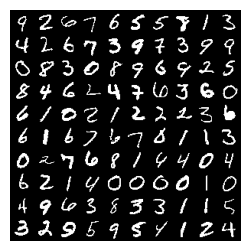

In [10]:
path = "emnist_to_mnist_unet_ConstantThermostat_gamma_0.5_max_0.0/run"
numbers = get_mnist_test_samples(path, which='target', class_label=None, sample_size=100, device="cuda:0")
mnist_grid(numbers, nrow=10, num_img=100, figsize=(3,3))

### show conditional paths

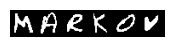

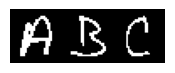

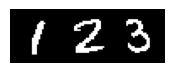

In [16]:
markov = torch.cat([letters[18].unsqueeze(0), 
                    letters[-24].unsqueeze(0), 
                    letters[-33].unsqueeze(0), 
                    letters[-21].unsqueeze(0), 
                    letters[-8].unsqueeze(0), 
                    letters[5].unsqueeze(0)], dim=0)  
mnist_grid(markov, nrow=6, num_img=6, figsize=(2,1))

source_ABC = torch.cat([letters[-24].unsqueeze(0), 
                 letters[8].unsqueeze(0), 
                 letters[-67].unsqueeze(0)], dim=0)  
mnist_grid(source_ABC, nrow=3, num_img=3, figsize=(2,1))

target_123 = torch.cat([numbers[-3].unsqueeze(0), 
                        numbers[1].unsqueeze(0), 
                        numbers[17].unsqueeze(0)], dim=0)  
mnist_grid(target_123, nrow=3, num_img=3, figsize=(2,1))

100%|██████████| 999/999 [00:07<00:00, 135.41it/s]


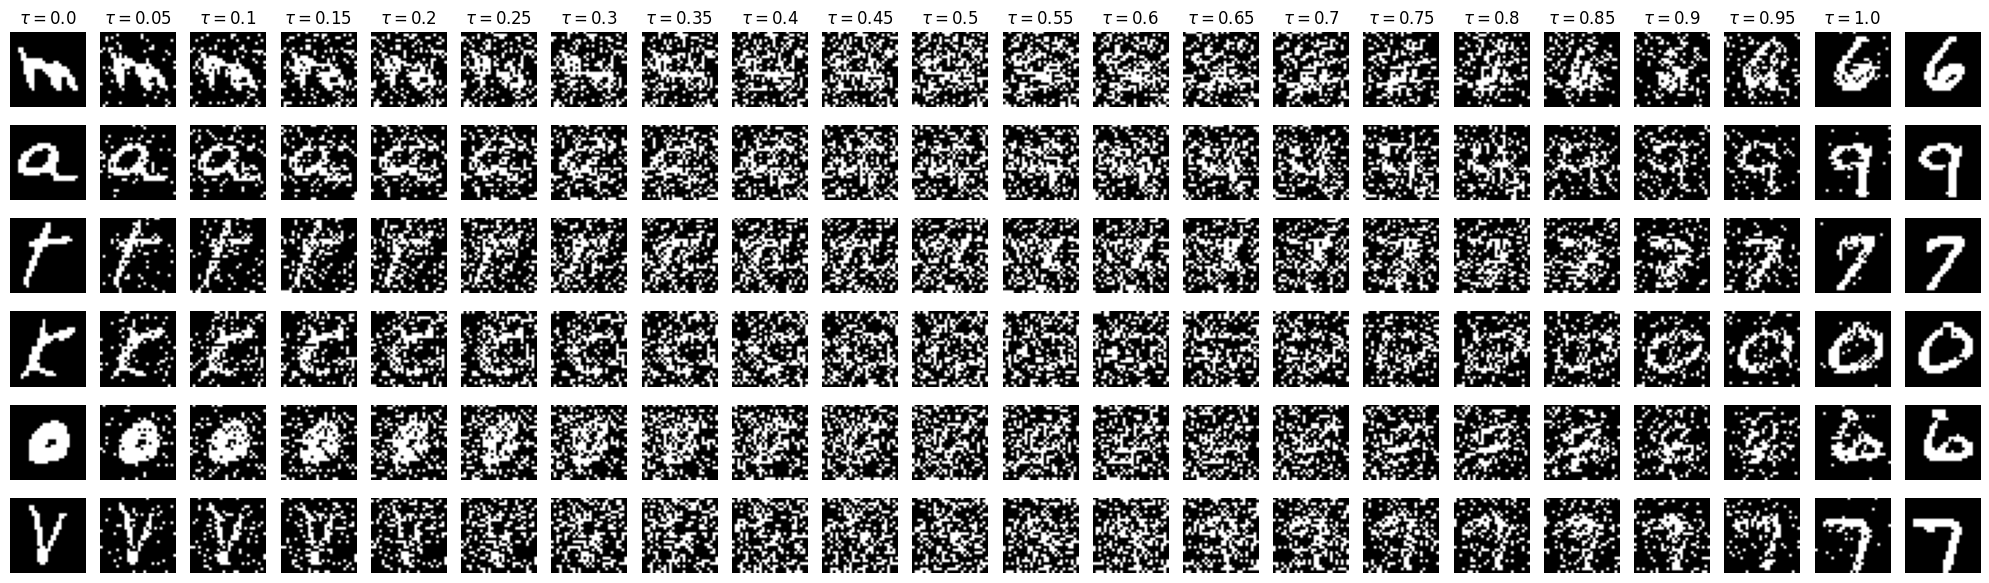

In [21]:
mnist_noise_bridge(path, markov, 
                   time_epsilon=0.005,
                   num_img=6, 
                   num_timesteps_displayed=20) 

constant thermostat with: $\gamma=0.05$:

100%|██████████| 999/999 [00:35<00:00, 28.33it/s]


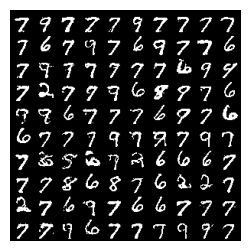

In [29]:
path = "emnist_to_mnist_unet_ConstantThermostat_gamma_0.05_max_0.0/run"
samples,_ , _ = generate_samples(path, letters, num_timesteps=1000,  time_epsilon=0.05, device="cuda:0")
mnist_grid(samples, num_img=100, nrow=10, figsize=(3,3))

100%|██████████| 999/999 [00:07<00:00, 133.71it/s]


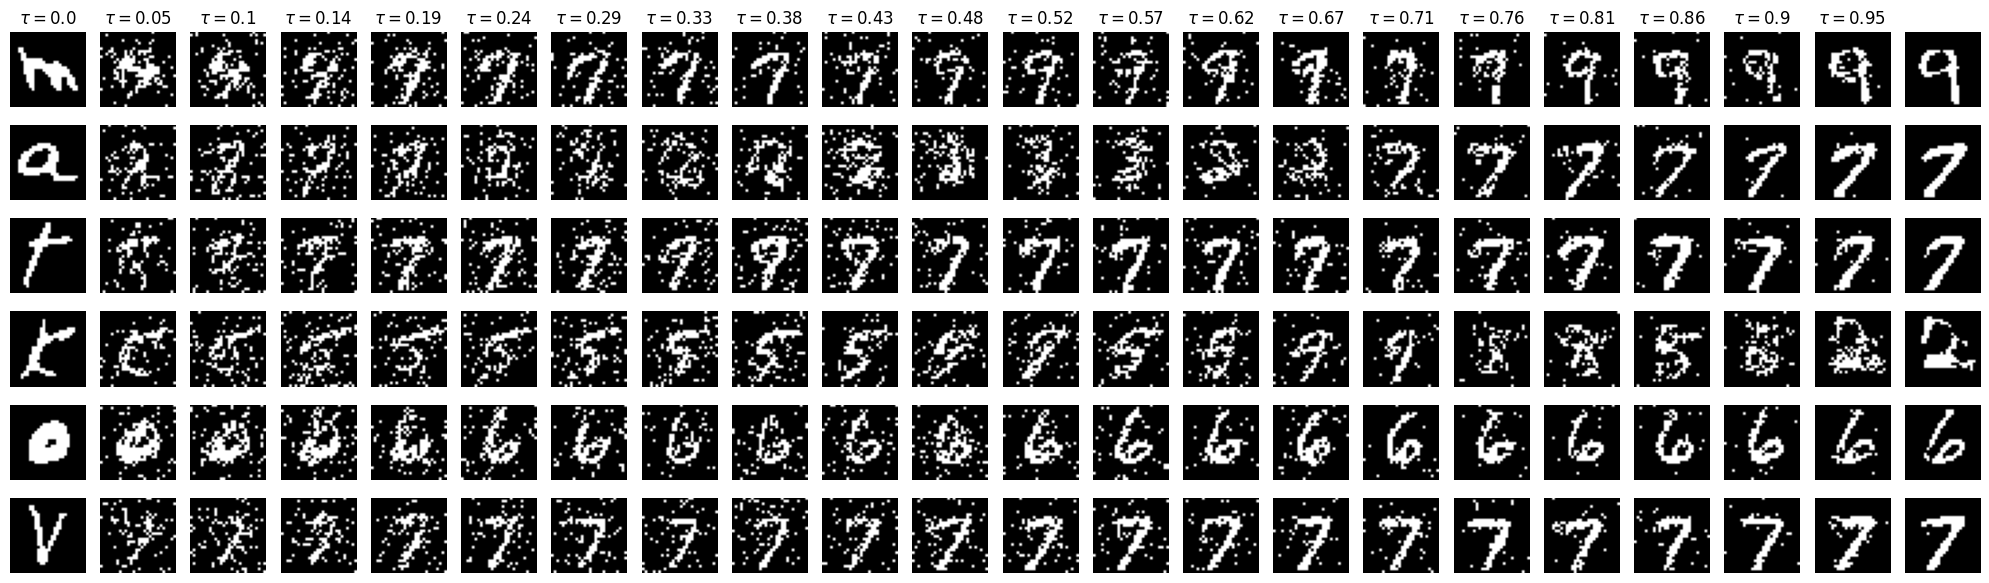

In [30]:
mnist_noise_bridge(path, markov, 
                   time_epsilon=0.05,
                   num_img=6, 
                   num_timesteps_displayed=20) 

In [4]:
path = "distorted_2_mnist_bridge/halfmask_mnist_to_mnist_mlp_0.01/run"
digits = get_mnist_test_samples(path, class_label=None, sample_size=100, device="cuda:0")
mnist_grid(digits, nrow=10, num_img=100, figsize=(3,3))

TypeError: BasicPipelineConfig.__init__() got an unexpected keyword argument 'time_epsilon'